In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from keras.callbacks import EarlyStopping
from keras.layers import Dropout
import re
from nltk.corpus import stopwords
from nltk import word_tokenize
import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


In [2]:
data = pd.read_csv('data/contracts.csv',sep=';', header=None, names=['contract','service_id','service_name','user_request'])

In [3]:
data.head()

,contract,service_id,service_name,user_request
0,354,4,Сантехник,лалсо
1,364,16,Сборка и ремонт мебели,заказ для Александра Трушкина
2,370,13,Ремонт компьютеров,заказ для Алишера
3,379,14,Муж на час,для Ерлана
4,385,14,Муж на час,мастер мастеров


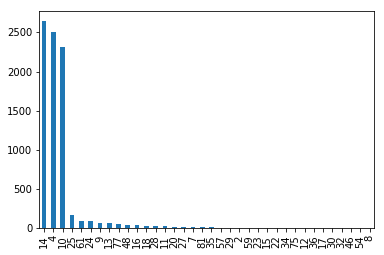

In [4]:
data.service_id.value_counts().plot(kind='bar')

In [5]:
data4 = data[~data.service_id.isin([14,10,4])].copy()
data4.head()

,contract,service_id,service_name,user_request
1,364,16,Сборка и ремонт мебели,заказ для Александра Трушкина
2,370,13,Ремонт компьютеров,заказ для Алишера
9,550,13,Ремонт компьютеров,где фото?
11,568,13,Ремонт компьютеров,видно имя?
13,573,13,Ремонт компьютеров,рейтинг нулевой


In [6]:
data.loc[~data.service_id.isin([14,10,4]), 'service_id'] = 0

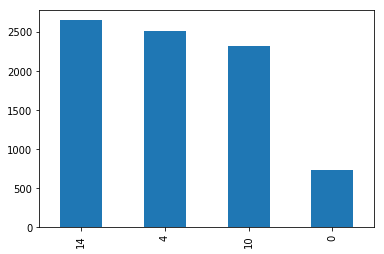

In [7]:
data.service_id.value_counts().plot(kind='bar')

In [8]:
vc = data4.service_id.value_counts().sort_values(ascending=False)[5:].index.tolist()
ind = data4[data4['service_id'].isin(vc)].index
data4.drop(ind, inplace=True)

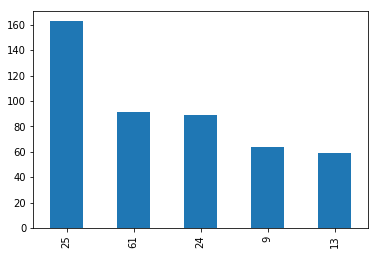

In [9]:
data4.service_id.value_counts().plot(kind='bar')

In [10]:

REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^а-я ]')

In [11]:
def remove_stopwords(text: str) -> str:
        try:
            text = text.lower()
            text = REPLACE_BY_SPACE_RE.sub(' ', text)
            text = BAD_SYMBOLS_RE.sub('', text)
            return " ".join([token for token in text.split() if token not in mystopwords])
        except:
            return ""
        
def lemmatize(text: str) -> str:
    try:
        return "".join(m.lemmatize(text)).strip()  
    except:
        return " "

def remove_stoplemmas(text: str) -> str:
    try:
        return " ".join([token for token in text.split() if token not in mystoplemmas])
    except:
        return ""

def clear_text(text: str) ->str:
    cText = remove_stopwords(text)
    cText = lemmatize(cText)
    cText = remove_stoplemmas(cText)
    return cText

In [13]:
from pymystem3 import Mystem
m = Mystem()

In [14]:
import nltk
nltk.download('stopwords')
mystopwords = stopwords.words('russian') + ['это', 'наш', 'тыс', 'млн', 'млрд', 'также',  'т', 'д','iKomek.kz','кв']
mystoplemmas = ['который', 'прошлый', 'сей', 'свой', 'наш', 'мочь']

[nltk_data] Downloading package stopwords to /home/mic/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [15]:
data['lemmas'] = data.user_request.apply(lambda x: clear_text(x))

In [24]:
data.head()

,contract,service_id,service_name,user_request,lemmas
0,354,4,Сантехник,лалсо,лалсо
1,364,0,Сборка и ремонт мебели,заказ для Александра Трушкина,заказ александр трушкин
2,370,0,Ремонт компьютеров,заказ для Алишера,заказ алишер
3,379,14,Муж на час,для Ерлана,ерлан
4,385,14,Муж на час,мастер мастеров,мастер мастер


In [49]:
# The maximum number of words to be used. (most frequent)
MAX_NB_WORDS = 50000
# Max number of words in each complaint.
MAX_SEQUENCE_LENGTH = 250
# This is fixed.
EMBEDDING_DIM = 50

tokenizer = Tokenizer(num_words=MAX_NB_WORDS)
tokenizer.fit_on_texts(data['lemmas'].values)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 4885 unique tokens.


In [50]:
X = tokenizer.texts_to_sequences(data['lemmas'].values)
X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', X.shape)

Shape of data tensor: (8199, 250)


In [51]:
Y = pd.get_dummies(data['service_id']).values
print('Shape of label tensor:', Y.shape)

Shape of label tensor: (8199, 4)


In [52]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=42)
print(X_train.shape,y_train.shape)
print(X_test.shape,y_test.shape)

(5739, 250) (5739, 4)
(2460, 250) (2460, 4)


In [53]:
model = Sequential()
model.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X.shape[1]))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(4, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 250, 50)           2500000   
_________________________________________________________________
spatial_dropout1d_2 (Spatial (None, 250, 50)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 100)               60400     
_________________________________________________________________
dense_2 (Dense)              (None, 4)                 404       
Total params: 2,560,804
Trainable params: 2,560,804
Non-trainable params: 0
_________________________________________________________________
None


In [54]:
epochs = 10
batch_size = 64
history = model.fit(
    X_train, 
    y_train, 
    epochs=epochs, 
    batch_size=batch_size,
    validation_split=0.2,
    callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)]
)

Train on 4591 samples, validate on 1148 samples
Epoch 1/10
4591/4591 [==============================] - 52s 11ms/step - loss: 1.2777 - acc: 0.4315 - val_loss: 1.1755 - val_acc: 0.6220
Epoch 2/10
4591/4591 [==============================] - 54s 12ms/step - loss: 0.8860 - acc: 0.6903 - val_loss: 0.7611 - val_acc: 0.7334
Epoch 3/10
4591/4591 [==============================] - 49s 11ms/step - loss: 0.6070 - acc: 0.7898 - val_loss: 0.6958 - val_acc: 0.7587
Epoch 4/10
4591/4591 [==============================] - 49s 11ms/step - loss: 0.4921 - acc: 0.8377 - val_loss: 0.6830 - val_acc: 0.7657
Epoch 5/10
4591/4591 [==============================] - 49s 11ms/step - loss: 0.4222 - acc: 0.8504 - val_loss: 0.6849 - val_acc: 0.7517
Epoch 6/10
4591/4591 [==============================] - 49s 11ms/step - loss: 0.3678 - acc: 0.8682 - val_loss: 0.6943 - val_acc: 0.7544
Epoch 7/10
4591/4591 [==============================] - 49s 11ms/step - loss: 0.3313 - acc: 0.8832 - val_loss: 0.7084 - val_acc: 0.7552


In [55]:
accr = model.evaluate(X_test,y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

2460/2460 [==============================] - 7s 3ms/step
Test set
  Loss: 0.702
  Accuracy: 0.749


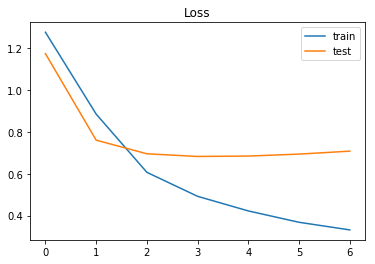

In [58]:
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show();

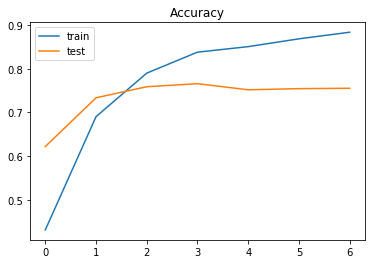

In [59]:
plt.title('Accuracy')
plt.plot(history.history['acc'], label='train')
plt.plot(history.history['val_acc'], label='test')
plt.legend()
plt.show();

In [62]:
test_text = 'собрать шкаф в спальне'
seq = tokenizer.texts_to_sequences([clear_text(test_text)])
padded = pad_sequences(seq, maxlen=MAX_SEQUENCE_LENGTH)
pred = model.predict(padded)

In [63]:
labels = ['Другие','Сантехник','Электрик','Муж на час']
print(pred, labels[np.argmax(pred)])

[[0.12067428 0.00646633 0.04940897 0.82345045]] Муж на час
